In [44]:
sys.path.append('./library') # age_gender_predictor
sys.path.append('../.env/lib/python2.7/site-packages')
import sys
import os 
import pickle
import age_gender_predictor
from collections import defaultdict
import re
from tabulate import tabulate
from datetime import datetime, timedelta
import math
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import pytz

## Load Regular User

In [2]:
timezone_location_dict = {
    'Pacific Time (US & Canada)':'US/Pacific',
    'Central Time (US & Canada)':'US/Central',
    'Eastern Time (US & Canada)':'US/Eastern',
    'London':'Europe/London',
    'Sydney':'Australia/Sydney',
    'Tokyo':'Asia/Tokyo',
    'Africa/Nairobi':'Africa/Nairobi',
    'Arizona':'US/Arizona',
    'Kyiv':'Europe/Simferopol',
    'Europe/London':'Europe/London',
    'Atlantic Time (Canada)':'Atlantic/Canary',
    'Midway Island':'Pacific/Apia',
    'Auckland':'Pacific/Auckland',
    'Amsterdam':'Europe/Amsterdam',
    'Baghdad':'Asia/Riyadh',
    'Riyadh':'Asia/Riyadh',
    'Belgrade':'Europe/Belgrade',
    'Quito':'Pacific/Galapagos',
    'Pretoria':'Africa/Johannesburg',
    'Beijing':'Asia/Shanghai',
    'Dublin':'Europe/Dublin',
    'Mountain Time (US & Canada)':'Mountain/US',
    'Hawaii':'Pacific/Honolulu',
    'Brisbane':'Australia/Brisbane',
    'Vienna':'Europe/Vienna',
    'Islamabad':'Asia/Karachi',
    'Casablanca':'Africa/Casablanca',
    'Yakutsk':'Asia/Yakutsk',
    'Tijuana':'America/Tijuana',
    'Johannesburg':'Africa/Johannesburg',
    'Mountain Time (US & Canada)':'US/Central',
    'Bangkok': 'Asia/Bangkok',
    'Harare': 'Africa/Harare',
    'Chennai': 'Asia/Kolkata',
    'Kolkata': 'Asia/Kolkata',
    'Brussels': 'Europe/Brussels',
    'Melbourne': 'Australia/Melbourne',
    'Alaska': 'US/Alaska',
    'Perth': 'Australia/Perth',
    'Denver':'America/Denver',
    'Los Angeles': 'America/Los_Angeles',
    'indiana': 'US/East-Indiana',
    'Vancouver': 'America/Vancouver',
    'Berlin': 'Europe/Berlin',
    'Kentucky': 'America/Kentucky/Louisville',
    'Copenhagen':'Europe/Copenhagen',
    'Athens': 'Europe/Athens',
    'Edinburgh': 'Etc/Greenwich',
    'Wellington': 'Asia/Anadyr',
    'Santiago': 'US/Pacific',
    'America/New_York': 'US/Eastern',
    'Paris': 'Europe/Paris',
    'Jakarta': 'Asia/Jakarta',
    'New Delhi': 'Asia/Calcutta',
    'Chicago': 'US/Central',
    'America/Chicago': 'US/Central',
    'Fiji': 'Pacific/Fiji'
}

def to_local_timezone(local, orig_time):
    dt = datetime.strptime(orig_time, "%Y-%m-%d %H:%M:%S")
    dt = pytz.timezone(local).localize(dt)
    est_dt = dt.astimezone(pytz.timezone('EST'))
    return est_dt

def readTimezone(folder, filename):
    time_dict = {}
    with open(folder + filename, 'r') as openfile:
        for line in openfile.readlines():
            split = line.strip().split('\t')
            if split[2] != 'None':
                time_dict[split[0]] = split[2]
            else:
                continue
    return time_dict

In [10]:
def checkFolderFile(folder):
    return os.listdir(folder)

In [14]:
regular_clean = []
regular_folder = './Regular/'
for regular_file in checkFolderFile(regular_folder):
    regular_clean.append(pd.read_pickle(regular_folder+regular_file))

In [15]:
len(regular_clean)

268

## Load BD

In [16]:
def date_not_in_range(user, ill_time_dict,date):
    if date >= ill_time_dict[user] - timedelta(days=42) \
    and date <= ill_time_dict[user] + timedelta(days=14):
        return False
    else:
        return True
    

In [17]:
bd_clean = []
bd_folder = './Bipolar/'
for bd_file in checkFolderFile(bd_folder):
    bd_clean.append(pd.read_pickle(bd_folder+bd_file))

In [18]:
len(bd_clean)

131

In [19]:
groups = [ regular_clean, bd_clean]
group_names = ["Regular", "Bipolar"]

In [20]:
#Statistics facts of experimental data

headers = ["Group","Users", "Tweets", "Average tweets"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    tweets_num = sum([timeSeries.shape[0] for timeSeries in group])
    users_num = len(group)
    average_tweets_num = tweets_num / users_num
    contents.append([group_name, users_num, tweets_num, average_tweets_num])
    
print(tabulate(contents, headers=headers))

Group      Users    Tweets    Average tweets
-------  -------  --------  ----------------
Regular      268     58461               218
Bipolar      131    142596              1088


## Age Gender

In [21]:
#Age and gender Distribution
def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

In [22]:
headers = ["Group","Male users", "Female users", "Average age"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
    users_num = float(len(group))
    users_gender = [getGender(timeSeries) for timeSeries in group]
    users_age = [getAge(timeSeries) for timeSeries in group]
    male_ratio = len([gender for gender in users_gender if gender < 0]) / users_num
    female_ratio = 1 - male_ratio
    average_age = sum(users_age) / users_num
    contents.append([group_name, male_ratio, female_ratio, average_age])
print(tabulate(contents, headers=headers))

Group      Male users    Female users    Average age
-------  ------------  --------------  -------------
Regular      0.488806        0.511194        30.1881
Bipolar      0.274809        0.725191        25.4797


## Social

1.43202416918429

In [108]:
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_tweets / float(total_duration)
    except:
        result = total_tweets / 1.0
    return result

def getLateTweetRate(timeSeries):
    total_late = 0
    for index in timeSeries.index:
        if int(index.hour) <6:
            total_late += 1
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    total_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    try:
        result = total_late / float(total_duration)
    except:
        result = total_late / 1.0
    return result

def getMentionRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / float(total_tweets)

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)
    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": [], "late_tweets_rate": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentionRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
        social_features["late_tweets_rate"].append(getLateTweetRate(timeSeries))
    return social_features

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getAgeGender]
    for method in methods:
        feature_set.update(method(group.getGroup(tail_k)))
    return feature_set


In [109]:
header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    tweets_rate = np.mean([getTweetRate(timeSeries) for timeSeries in group])
    mention_rate = np.mean([getMentionRate(timeSeries) for timeSeries in group])
    unique_mentions = np.mean([getUniqueMentions(timeSeries) for timeSeries in group])
    frequent_mention = np.mean([getFrequentMentions(timeSeries) for timSeries in group]) 
    late_tweets_rate = np.mean([getLateTweetRate(timeSeries) for timeSeries in group])
    content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
    contents.append(content)


print("\n======Mean Distribution======\n")

print(tabulate(contents, headers=header,))


======Mean Distribution======

           tweets_rate    late_tweets_rate    mention_rate    unique_mentions    frequent_mentions
-------  -------------  ------------------  --------------  -----------------  -------------------
Regular        4.26146             1.28674        0.426162            46.6679                    1
Bipolar       20.4919              5.89845        0.388548           104.046                   161


In [114]:
header = ["tweets_rate", "late_tweets_rate", "mention_rate", "unique_mentions", "frequent_mentions"]
contents = []
for i, timeSeries in enumerate(regular_clean):
   
    content = [i]
    tweets_rate = getTweetRate(timeSeries)
    mention_rate = getMentionRate(timeSeries)
    unique_mentions = getUniqueMentions(timeSeries)
    frequent_mention = getFrequentMentions(timeSeries)
    late_tweets_rate = getLateTweetRate(timeSeries)
    content += [tweets_rate, late_tweets_rate, mention_rate, unique_mentions, frequent_mention]
    contents.append(content)


print("\n======Mean Distribution======\n")

print(tabulate(contents, headers=header,))


======Mean Distribution======

       tweets_rate    late_tweets_rate    mention_rate    unique_mentions    frequent_mentions
---  -------------  ------------------  --------------  -----------------  -------------------
  0       1.35542            0.650602       0.173333                   15                    0
  1       6.06552            2.32137        0.645062                  151                   20
  2       1.59165            0.214605       0.516854                   41                   10
  3       5.96844            1.80316        0.404834                   39                   15
  4       1.50336            0              0.190476                    8                    3
  5       6.93652            2.20463        0.232558                   45                   11
  6       0.490166           0.217852       0.518519                   11                    1
  7      73.2881            25.5246         0.586801                   55                   42
  8       0.522915

## Polarity Feature

In [150]:
def getFlipsCount(timeSeries, upperbound=120, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / float(total_tweets)

def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / float(total_tweets)

def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        try:
            tweets_length = float(timeSeries.shape[0])
        except:
            print 'error'
            print timeSeries
            break
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity

def comboTracker(timeSeries, attribute= "polarity", lowerbound = 120):
    array = timeSeries[attribute]
#     the polarity of starter
    starter = array[0]
    combo = 1
    result = []
    i = 0 
#     begin from second one in the array
    for cursor in array[1:]:
        i += 1
        if starter == cursor and timeSeries["dt"][i-1] < lowerbound:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

In [151]:
headers = ["Group","Positive Ratio","Negative Ratio", "Flip Ratio", "Positive Combos", "Negative Combos"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratio_mean = np.mean([getPositiveRatio(timeSeries) for timeSeries in group])
    negative_ratio_mean = np.mean([getNegativeRatio(timeSeries) for timeSeries in group])
    flips_ratio_mean = np.mean([getFlipsCount(timeSeries) / float(len(timeSeries)) for timeSeries in group])
    negative_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=-1) / float(len(timeSeries)) for timeSeries in group])
    positive_combos_ratio = np.mean([getCombosCount(timeSeries,matcher=1) / float(len(timeSeries)) for timeSeries in group])
    
    contents.append([group_name, positive_ratio_mean, negative_ratio_mean, flips_ratio_mean, positive_combos_ratio, negative_combos_ratio])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group      Positive Ratio    Negative Ratio    Flip Ratio    Positive Combos    Negative Combos
-------  ----------------  ----------------  ------------  -----------------  -----------------
Regular         0.223516           0.107087    0.00397308         0.0307636          0.00364134
Bipolar         0.0924273          0.177112    0.00571553         0.00707838         0.0181003


In [125]:
headers = ["Group","Positive Ratio Mean","Positive Ratio STD", "Negative Ratio Mean", "Negative Ratio STD"]
contents = []
for i, group in enumerate(groups):
    group_name = group_names[i]
   
    positive_ratios = [getPositiveRatio(timeSeries) for timeSeries in group]
    negative_ratios = [getNegativeRatio(timeSeries) for timeSeries in group]
    positive_ratio_mean = np.mean(positive_ratios)
    negative_ratio_mean = np.mean(negative_ratios)
    positive_ratio_std = np.std(positive_ratios)
    negative_ratio_std = np.std(negative_ratios)

    contents.append([group_name, positive_ratio_mean, positive_ratio_std, negative_ratio_mean, negative_ratio_std])
print("\n=========\n")
print(tabulate(contents, headers=headers))



Group      Positive Ratio Mean    Positive Ratio STD    Negative Ratio Mean    Negative Ratio STD
-------  ---------------------  --------------------  ---------------------  --------------------
Regular              0.223516              0.156083                0.107087             0.0834606
Bipolar              0.0924273             0.0665547               0.177112             0.0831466


## Emotion

In [27]:
def date_not_in_range(user, date):
    if date >= patient_month_time_dict[user] - timedelta(days=42) \
    and date <= patient_month_time_dict[user] + timedelta(days=14):
        return False
    else:
        return True

    


def getUsersEmotionsDict(users_timeSeries):
#     user -> emotion count
    user_emotion_dict = defaultdict(lambda: {"joy":0,
                                       "sadness": 0,
                                       "fear":0,
                                       "anticipation": 0,
                                       "anger":0,
                                       "trust": 0,
                                       "disgust": 0,
                                       "surprise" : 0
                                      })
    for user in users_timeSeries:
        user_tweets_count = 0
#         date, [tweet_info, tweets_info ...]
        for date, tweets_infos in users_timeSeries[user].iteritems():
            if date_not_in_range(user, datetime.strptime(str(date), "%Y%m%d")): continue
            for tweet_info in tweets_infos:                
    #             content, emotion1, emotion2, ambiguous
                if(tweet_info[3].strip() != 'yes'):
    #         only get the first emotion now
                    user_emotion_dict[user][tweet_info[1]] += 1
                    user_tweets_count += 1
    
        for emotion in user_emotion_dict[user]:
            if user_tweets_count == 0:
                user_emotion_dict[user][emotion] = 0
            else:
                user_emotion_dict[user][emotion] = float(user_emotion_dict[user][emotion]) / user_tweets_count
    return user_emotion_dict

def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    if float(filtered_emotions.shape[0]) == 0:
        divider = 1.0
    else:
        divider = float(filtered_emotions.shape[0])
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / divider
    return emotions_count

def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts



In [28]:
emotions = ["joy","sadness","fear", "anticipation", "anger", "trust", "disgust" ,"surprise"]

headers = ["Group"] + emotions
contents = []
for i, group in enumerate(groups):
   
    group_name = group_names[i]
    content = [group_name]
    emotions_counts = getGroupEmotions(group)
    for emotion in emotions:
        emotion_ratio = "{}%".format(round(np.mean(emotions_counts[emotion])*100, 2))
        
        content.append(emotion_ratio)
    contents.append(content)
    
print("\n======Eight Emotional Features======\n")

print("\n======Distribution======\n")

print(tabulate(contents, headers=headers,))



======Eight Emotional Features======


======Distribution======

Group    joy     sadness    fear    anticipation    anger    trust    disgust    surprise
-------  ------  ---------  ------  --------------  -------  -------  ---------  ----------
Regular  16.36%  26.24%     6.46%   14.26%          6.82%    15.1%    11.52%     3.24%
Bipolar  13.63%  28.25%     4.15%   14.6%           11.32%   6.55%    16.72%     4.79%


## Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

import matplotlib.pyplot as plt
from random import randint
from operator import itemgetter 
import time

In [32]:
#Wrap group to be object
class Group(object):
    def __init__(self, group_name, group_data_list):
        self.name = group_name
        self.timeSerieses_list = group_data_list
        
    def getName(self):
        return self.name
    
    def getSize(self):
        return len(self.timeSerieses_list)
    
    def getGroup(self, tail_k="all"):
        if tail_k =="all":
            return self.timeSerieses_list
        else:
            return [timeSeries.tail(tail_k) for timeSeries in self.group]

In [33]:
bipolar_group = Group("Bipolar", bd_clean)
regular_group = Group("Regular", regular_clean)

In [152]:
def getCategories(group):
    name2category = {}
    names = ["Social", "Emotions", "Polarity", "AgeGender"]
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getAgeGender]
    for i, method in enumerate(methods):
        feature = method(group.getGroup())
        for key in feature:
            name2category[key] = names[i]
    return name2category

In [189]:
class POLFeaturerGroups(object):
    
    @staticmethod
    def transform(self, ):
        features_dict = getAllFeature(group)
        
    
    def __init__(self, base, groups):
        feature2categories = getCategories(base)
        self.groups = groups
        self.base = base
        self.categories = set(feature2categories.values())
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
        self.base_name = base.getName()
        self.index2feature = []
        base_feature_dict = getAllFeature(base)
        self.base_feature = np.zeros((base.getSize(),len(base_feature_dict)), dtype = float)
        for name, values in base_feature_dict.items():
            cursor = len(self.index2feature)
          
            self.base_feature[:,cursor] = values
            category = feature2categories[name]
            self.index2feature.append((name, category))
        

        self.features = [self.group2feature(group) for group in groups]
        
    def group2feature(self, group, tail_k="all", selection = "all"):

        features_dict = getAllFeature(group, tail_k)
        feature = np.zeros((group.getSize(),len(self.index2feature)),dtype=float)
        for cursor, (name,category) in enumerate(self.index2feature):
            value = features_dict[name]
            feature[:,cursor] = value
            
        if selection == "all":
            return feature
        else:
            return feature[:,selection]   

    def getPrecision(self,name,selection="all",tail_k="all",n_fold=10,classifier = "forest"):
        complete_X, Y = self.getLabeledData(name, selection)
        index = self.name_to_index[name]
        group = self.groups[index]
        tailed_X = preprocessing.scale(self.group2feature(self.base + group, tail_k=tail_k, selection = selection))
        complete_X = preprocessing.scale(complete_X)
        
        tailed_X[np.isinf(tailed_X)] = 0
        tailed_X[np.isnan(tailed_X)] = 0
        
        precisions = []
        if classifier == "forest":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
  
        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.3, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            imputer = Imputer()
        
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)
           
            
        return np.mean(precisions)
            
        
        
    def getLabeledData(self,name, selection = "all"):
        if selection is "all":
            selection = range(len(self.index2feature))
        
        base_feature = self.base_feature[:,selection]
        base_length = base_feature.shape[0]
        index = self.name_to_index[name]
        feature = self.features[index][:,selection]

        X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
        X[0:base_length ,:] = base_feature
        X[base_length:,:] = feature
        Y = np.array([0]*base_length  + [1]*feature.shape[0])
        
        return X, Y
    
    def getFeatureImportance_all(self,name):
        X, Y = self.getLabeledData(name)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    def getFeature(self, name, selection="all"):
        if selection is "all":
            selection = list(range(len(self.index2feature)))
        index = self.name_to_index[name]
        feature =  self.features[index]
        return feature[:, selection]
    
    def classify(self,name, target_name, selection="all"):
        X, Y = self.getLabeledData(name, selection)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        test_x = self.getFeature(target_name,selection)
        return classifier.predict(test_x)
       
    def getLabelsScores(self, name, classifier,n_fold, selection):
        SCORES = np.array([])
        LABELS = np.array([])
        
        X, Y = self.getLabeledData(name, selection)
        
        sss = StratifiedShuffleSplit(Y, n_fold, test_size = 0.3, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
    
    def renderPrecisionRecall_all(self, name,colors=['r','g','b',"y", "m"], n_fold = 100):
        classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')
        ax.title.set_color('white')
#         ax.yaxis.label.set_color('white')
#         ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        categories = list(self.categories) + ["All"]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category == feature_category]
            
            SCORES, LABELS, (X_train, X_test,Y_train, Y_test) = self.getLabelsScores(name, classifier,n_fold, selection)
            
            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)

            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test
           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=2)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()


In [190]:
pol_groups = POLFeaturerGroups(regular_group, [bipolar_group])

187 Normal and 92 Bipolar in Training Data
81 Normal and 39 Bipolar in Test Data



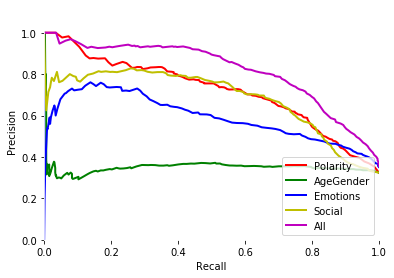

In [191]:
#Compare the performance of each Pattern of Life components and LIWC
pol_groups.renderPrecisionRecall_all("Bipolar",n_fold=20)

In [197]:
#Dump the pre-trained models
feature_order = ['tweets_rate', 'mention_rate','unique_mentions','frequent_mentions','positive_ratio',\
                 'negative_ratio','flips','negative_combos','positive_combos', 'age', 'gender' ]
online_selection = []

for feature_name in feature_order:
    for i,(name, category) in enumerate(pol_groups.index2feature):
        if name == feature_name:
            online_selection.append(i)




classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

X, Y = pol_groups.getLabeledData("Bipolar", selection=online_selection)
classifier.fit(X,Y)
joblib.dump(classifier,"models/bipolar_forest/bipolar_forest_0")

['models/bipolar_forest/bipolar_forest_0',
 'models/bipolar_forest/bipolar_forest_0_01.npy',
 'models/bipolar_forest/bipolar_forest_0_02.npy',
 'models/bipolar_forest/bipolar_forest_0_03.npy',
 'models/bipolar_forest/bipolar_forest_0_04.npy',
 'models/bipolar_forest/bipolar_forest_0_05.npy',
 'models/bipolar_forest/bipolar_forest_0_06.npy',
 'models/bipolar_forest/bipolar_forest_0_07.npy',
 'models/bipolar_forest/bipolar_forest_0_08.npy',
 'models/bipolar_forest/bipolar_forest_0_09.npy',
 'models/bipolar_forest/bipolar_forest_0_10.npy',
 'models/bipolar_forest/bipolar_forest_0_11.npy',
 'models/bipolar_forest/bipolar_forest_0_12.npy',
 'models/bipolar_forest/bipolar_forest_0_13.npy',
 'models/bipolar_forest/bipolar_forest_0_14.npy',
 'models/bipolar_forest/bipolar_forest_0_15.npy',
 'models/bipolar_forest/bipolar_forest_0_16.npy',
 'models/bipolar_forest/bipolar_forest_0_17.npy',
 'models/bipolar_forest/bipolar_forest_0_18.npy',
 'models/bipolar_forest/bipolar_forest_0_19.npy',
 'model

# Precission Recall Chart on 10-fold cross-validation

Pattern of Life under curve area: 0.90067008547


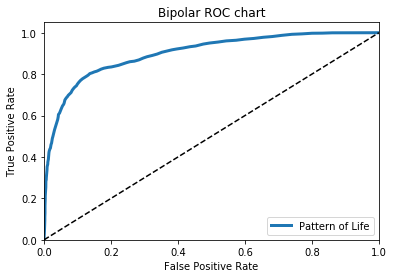

Pattern of Life Average Precision: 0.837631026358


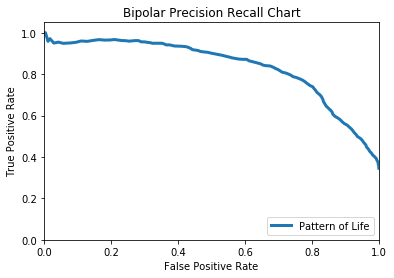

In [196]:
 
index2feature = pol_groups.index2feature

def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            #removed_features.append(name)
            pass
        elif any(name == x for x in excluded_index):
            #removed_features.append(name)
            pass

        else:                   
            selection.append(i)
    return selection


POL_selection = getSelection(excluded_categories=["LIWC"])

#ROC chart of three models:
def renderROC(scores, labels,disorder ,names, linestyle=['solid','dashed','dotted']):
    fig, ax = plt.subplots()
    for i,(score, label) in enumerate(zip(scores, labels)):
        fpr, tpr, _ = roc_curve(label,score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} under curve area: {}".format(names[i],roc_auc))

   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

names = ["Pattern of Life"]
classifier  = RandomForestClassifier(n_jobs= -1, max_features="sqrt", n_estimators=128)
name = "Bipolar"
n_fold = 50
POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier, n_fold=n_fold, selection=POL_selection)

bipolar_SCORES = [POL_scores]
bipolar_LABELS = [POL_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)

POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=POL_selection)

#np.sum(tfidf_labels)

def renderPRC(scores, labels,disorder ,names, linestyle=['solid','dashed','dashdot']):
    fig, ax = plt.subplots()
    for i,(score, label) in enumerate(zip(scores, labels)):
        
        precision, recall, _ = precision_recall_curve(label, score, pos_label=1)
        average_precision = average_precision_score(label, score)

        plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} Average Precision: {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()
    
renderPRC(bipolar_SCORES, bipolar_LABELS, "Bipolar",names)